In [100]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from random import seed, shuffle
import os
from pathlib import Path
import glob
from datetime import datetime

import librosa

from pyannote.audio import Pipeline
from pyannote.core import json

from matplotlib import pyplot as plt, lines
import seaborn as sns

from sklearn.manifold import TSNE
import umap
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler

from scipy import stats
from scipy.spatial.distance import directed_hausdorff, euclidean, cosine, pdist

from src import (
    downsample as downsamp_audio, 
    embedding_extractor as ee, 
    dimension_reducer as dr, 
    distance_metrics as dm, 
    downsample as ds,
    emb_manipulator as em
)

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
emb_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/embeddings'
#files = ['03016_diarized_pyv2.csv','2022_06_01_emb.csv']
files = ['IV_001-020_0316.csv','IV_021-023-BB003_0601.csv','spont_script_all_0606.csv']

emb_unscaled = pd.DataFrame()

for f in files:
    temp = pd.read_csv(os.path.join(emb_dir,f), index_col=0)
    temp['data_set'] = [Path(f).stem]*temp.shape[0]
    emb_unscaled = pd.concat([emb_unscaled,temp], ignore_index=True)

#emb_down_unscaled = em.resample_data(emb,1)

scaler = StandardScaler()
emb = pd.DataFrame(scaler.fit_transform(emb_unscaled.drop(columns=['part_id','data_set'])))
#emb['part_id'] = emb_unscaled.part_id.astype('string').to_numpy()
#emb['data_set'] = emb_unscaled.data_set.astype('string').to_numpy()

pid = []
sex_list = []
for name,corpus in zip(emb_unscaled.part_id, emb_unscaled.data_set):
    name = str(name)
    if corpus == 'IV_001-020_0316' or corpus == 'IV_021-023-BB003_0601':
        pid.append(name.split("_")[0].zfill(3))
        sex_list.append('F')
    elif corpus == 'spont_script_all_0606':
        pid.append(name.split("_")[0].zfill(3))# + "_" + name.split("_")[3])
        sex_list.append(name.split("_")[1])

emb['part_id'] = pid
emb['sex'] = sex_list
emb['data_set'] = emb_unscaled.data_set.astype('string').to_numpy()

labels = ['part_id', 'data_set','sex']

In [10]:
X= emb.drop(columns=labels)
#metric = 'cosine'
metric = 'euclidean'

tsne = TSNE(n_components=2, perplexity=60, init = 'pca', random_state=20, metric=metric)
umap = umap.UMAP(n_components=2,metric=metric)

Xtsne = tsne.fit_transform(X)
Xumap = umap.fit_transform(X)

[Text(0.5, 1.0, 'tsneeuclidean')]

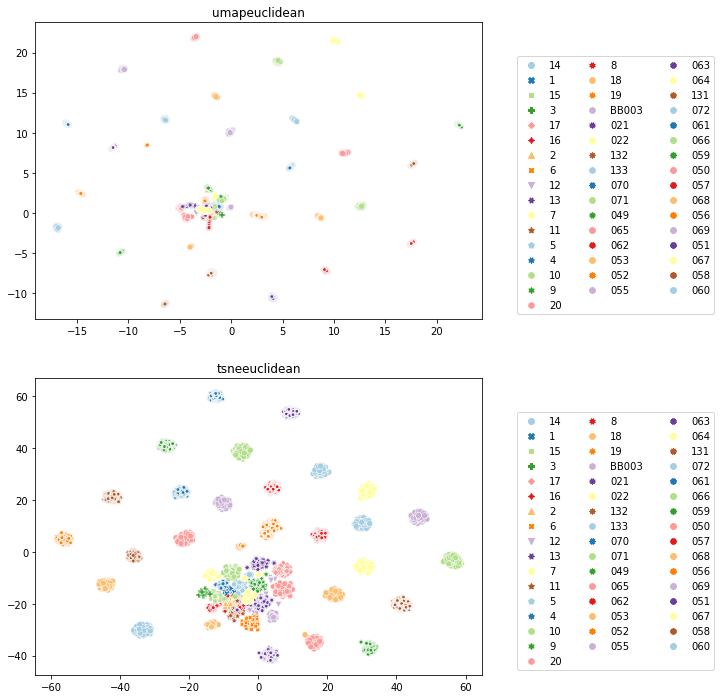

In [15]:
##plot 2 dimensions from each dimension reduction
fig, (ax1,ax2) = plt.subplots(2,figsize=(8,12))

clust_plt_umap = sns.scatterplot(x=Xumap[:,0], y=Xumap[:,1], ax=ax1, palette="Paired", hue=emb.part_id, style=emb.part_id, legend=True)
ax1.legend(loc="lower center",bbox_to_anchor=(1.3,  0), ncol=3)
clust_plt_umap.set(title = 'umap' + metric)

clust_plt_tsne = sns.scatterplot(x=Xtsne[:,0], y=Xtsne[:,1], ax=ax2, palette="Paired", hue=emb.part_id, style=emb.part_id,legend=True)
ax2.legend(loc="lower center",bbox_to_anchor=(1.3,  0), ncol=3)
clust_plt_tsne.set(title = 'tsne' + metric)

[Text(0.5, 1.0, 'tsneeuclidean')]

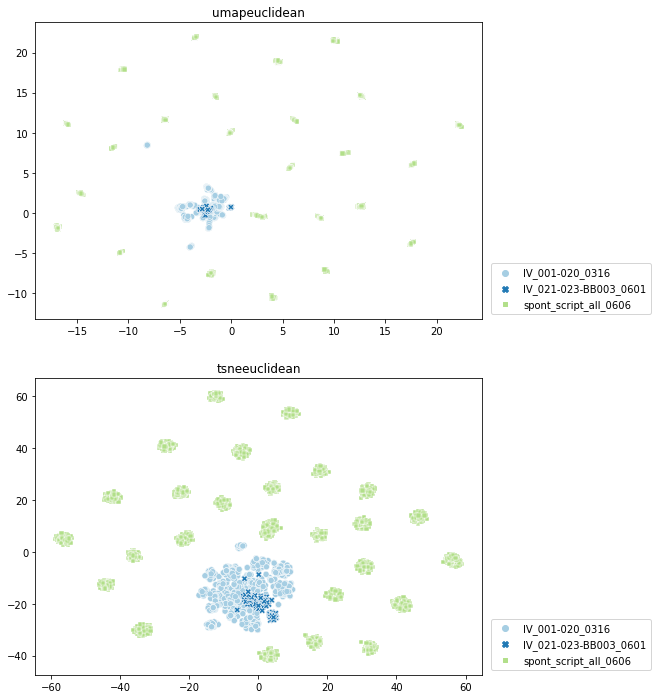

In [13]:
##plot 2 dimensions from each dimension reduction
fig, (ax1,ax2) = plt.subplots(2,figsize=(8,12))

clust_plt_umap = sns.scatterplot(x=Xumap[:,0], y=Xumap[:,1], ax=ax1, palette="Paired", hue=emb.data_set, style=emb.data_set, legend=True)
ax1.legend(loc="lower center",bbox_to_anchor=(1.2,  0), ncol=1)
clust_plt_umap.set(title = 'umap' + metric)

clust_plt_tsne = sns.scatterplot(x=Xtsne[:,0], y=Xtsne[:,1], ax=ax2, palette="Paired", hue=emb.data_set, style=emb.data_set,legend=True)
ax2.legend(loc="lower center",bbox_to_anchor=(1.2,  0), ncol=1)
clust_plt_tsne.set(title = 'tsne' + metric)

[Text(0.5, 1.0, 'tsneeuclidean')]

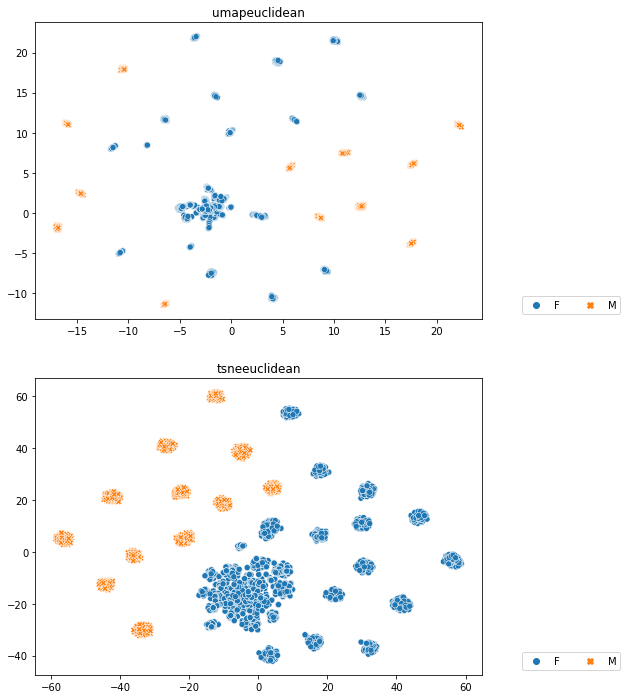

In [31]:
##plot 2 dimensions from each dimension reduction
fig, (ax1,ax2) = plt.subplots(2,figsize=(8,12))

clust_plt_umap = sns.scatterplot(x=Xumap[:,0], y=Xumap[:,1], ax=ax1, hue=emb.sex, style=emb.sex, legend=True)
ax1.legend(loc="lower center",bbox_to_anchor=(1.2,  0), ncol=2)
clust_plt_umap.set(title = 'umap' + metric)

clust_plt_tsne = sns.scatterplot(x=Xtsne[:,0], y=Xtsne[:,1], ax=ax2, hue=emb.sex, style=emb.sex,legend=True)
ax2.legend(loc="lower center",bbox_to_anchor=(1.2,  0), ncol=2)
clust_plt_tsne.set(title = 'tsne' + metric)

In [36]:
Xumap_df = pd.DataFrame(Xumap, columns=['dim0', 'dim1'])
Xumap_df['part_id'] = emb.part_id.to_numpy()
Xtsne_df = pd.DataFrame(Xtsne, columns=['dim0', 'dim1'])
Xtsne_df['part_id'] = emb.part_id.to_numpy()

d_umap = dm.hausdorff_distances(Xumap_df)
d_tsne = dm.hausdorff_distances(Xtsne_df)

Processing row 48, col 48


In [38]:
target = 'BB003'
d_umap[target].abs().nlargest(n=6)

059    24.503519
067    23.216715
065    21.552784
055    20.327050
061    19.162675
064    18.868959
Name: BB003, dtype: float64

In [37]:
d_tsne[target].abs().nlargest(n=6)

061    86.377619
051    78.632961
059    73.215142
052    68.427907
131    66.150753
066    64.752962
Name: BB003, dtype: float64

In [39]:
d_umap_flat = pd.DataFrame(d_umap.to_numpy().flatten()).dropna()
d_tsne_flat = pd.DataFrame(d_tsne.to_numpy().flatten()).dropna()

d_umap_flat.corrwith(d_tsne_flat)

0    0.562002
dtype: float64

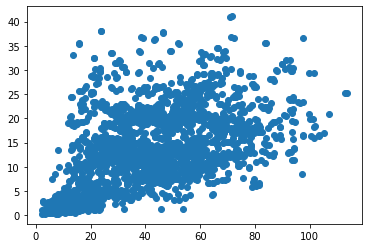

In [40]:
plt.scatter(d_tsne_flat,d_umap_flat)

In [47]:
knn=50
knn_classes=10
subsetsize=1000

#we are always comparing to emb_down as our high-dimension embedding. 
high_dim = X.to_numpy()
classes= emb.part_id.to_numpy() #extract the categories/labels

#compare tsne to embeddings
low_dim = Xtsne
dist_tsne = dm.embedding_quality(high_dim, low_dim, classes, knn=knn, knn_classes=knn_classes, subsetsize=subsetsize)

#compare umap to embeddings
low_dim = Xumap
dist_umap = dm.embedding_quality(high_dim, low_dim, classes, knn=knn, knn_classes=knn_classes, subsetsize=subsetsize)


#create a dataframe of all distance metrics for each dimension method
dist = pd.DataFrame(np.vstack((dist_tsne, dist_umap)), columns = ['micro', 'meso', 'macro'], index = ['tsne', 'umap'])
#dist = pd.DataFrame(dist_tsne, dist_umap, index = ['micro', 'meso', 'macro'], columns= ['tsne','umap'])
dist = dist.round(decimals=3)

In [48]:
dist

,micro,meso,macro
tsne,0.625,0.514,0.441
umap,0.548,0.412,0.324


In [50]:
part_1_20 = r'/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/0300222_recordings_16khz'
part_21_23_BB03 = r'/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/053122_new_participants/audio_16kHz'
spont_script = "/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/gasser_readings/preprocessed_audios_dur3sec"

part_1_20_rec = glob.glob(part_1_20 + '/*',  recursive=True)
part_21_23_BB03_rec = glob.glob(part_21_23_BB03 + '/*',  recursive=True)

script_rec = glob.glob(spont_script+'/*/*', recursive=True)
script_rec = [file for file in script_rec if 'script' in file]


wav_files = part_1_20_rec + part_21_23_BB03_rec + script_rec

wav_data = {Path(wav).stem.split("_")[0]:librosa.load(wav, sr=16000, mono=True) for wav in wav_files}

In [51]:
## shape/(framelength/4) + 1 = num_embed
## num_embed-1 = shape/(framelength/4)
## 1/(num_embed-1) = (framelength/4)/shape
## shape/(num_embed-1) = framelength/4
## 4 * shape/(num_embed-1) = framelength
#frame_length = 4*l//(emb.shape[0]-1)

f0 = {part:librosa.yin(wav[0], 
                  sr=16000,
                  fmin = 50, 
                  fmax= 600) 
      for part,wav in wav_data.items()}

In [52]:
f0_median = {part:np.median(f) for part,f in f0.items()}

for wav in wav_files:
    temp = emb[emb.part_id==Path(wav).stem]
    emb.loc[emb.part_id==Path(wav).stem.split("_")[0], 'f0'] = f0_median[Path(wav).stem.split("_")[0]]

[Text(0.5, 1.0, 'tsneeuclidean')]

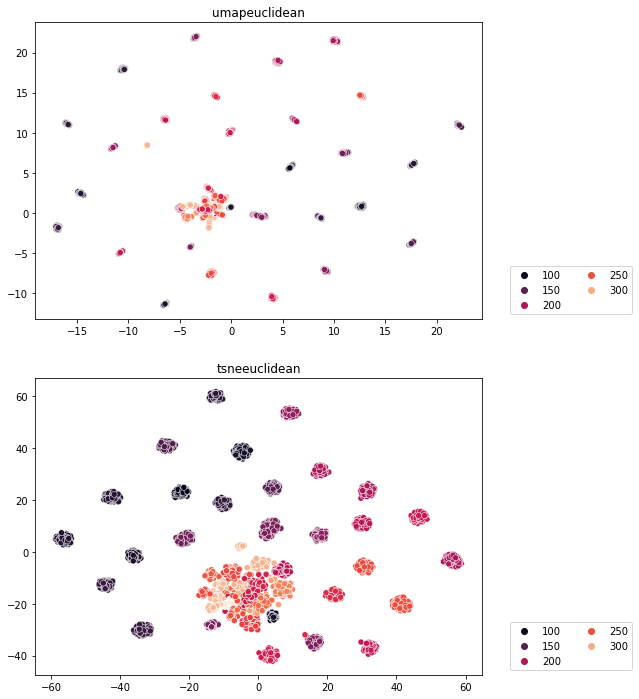

In [53]:
##plot 2 dimensions from each dimension reduction
fig, (ax1,ax2) = plt.subplots(2,figsize=(8,12))

clust_plt_umap = sns.scatterplot(x=Xumap[:,0], y=Xumap[:,1], ax=ax1, palette="rocket",hue=emb.f0, legend=True)
ax1.legend(loc="lower center",bbox_to_anchor=(1.2,  0), ncol=2)
clust_plt_umap.set(title = 'umap' + metric)

clust_plt_tsne = sns.scatterplot(x=Xtsne[:,0], y=Xtsne[:,1], ax=ax2, palette="rocket", hue=emb.f0, legend=True)
ax2.legend(loc="lower center",bbox_to_anchor=(1.2,  0), ncol=2)
clust_plt_tsne.set(title = 'tsne' + metric)

In [139]:
gemap_file = os.path.join(emb_dir,'060722_segmented_23moms_scripted_3sec.csv')

gemap_unscaled = pd.read_csv(gemap_file, index_col=0)
gemap_unscaled = gemap_unscaled.drop(columns=['start','end'])

scaler = StandardScaler()
gemap = pd.DataFrame(scaler.fit_transform(gemap_unscaled.drop(columns='part_id')), columns=gemap_unscaled.columns[:-1])
gemap['part_id'] = [part.zfill(3) for part in gemap_unscaled.part_id.to_numpy()]


In [142]:
corpus = []
sex_list = []
for name in gemap_unscaled.index:
    name = str(name)
    name = Path(name).stem
    if 'script' in name:
        corpus.append('spont_script')
        sex_list.append(name.split("_")[1])
    else:
        corpus.append("IV")# + "_" + name.split("_")[3])
        sex_list.append("F")

gemap['data_set'] = corpus
gemap['sex'] = sex_list

In [81]:
Y = gemap.drop(columns=labels)

metric = 'euclidean'

tsne = TSNE(n_components=2, perplexity=60, init = 'pca', random_state=20, metric=metric)
umap = umap.UMAP(n_components=2,metric=metric)

Ytsne = tsne.fit_transform(Y)
Yumap = umap.fit_transform(Y)


[Text(0.5, 1.0, 'tsneeuclidean')]

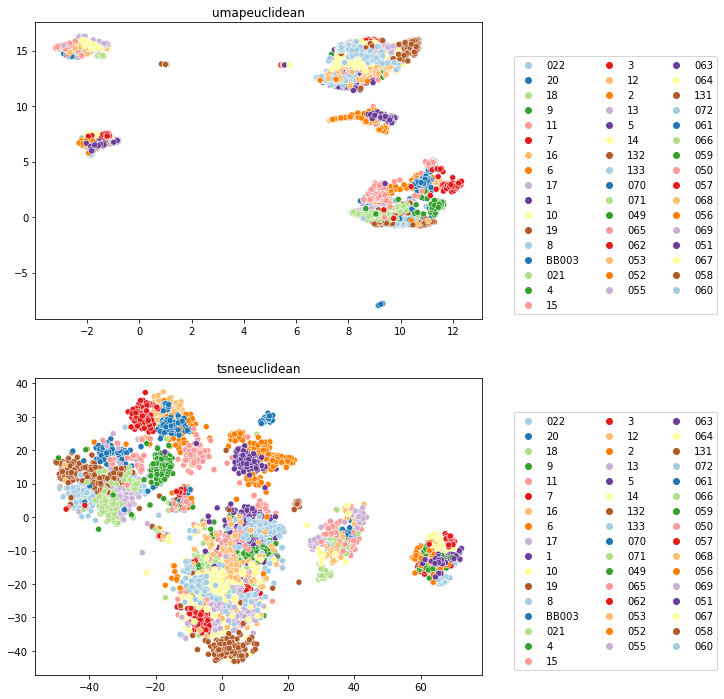

In [84]:
##plot 2 dimensions from each dimension reduction
fig, (ax1,ax2) = plt.subplots(2,figsize=(8,12))

clust_plt_umap = sns.scatterplot(x=Yumap[:,0], y=Yumap[:,1], ax=ax1, palette="Paired",hue=gemap.part_id, legend=True)
ax1.legend(loc="lower center",bbox_to_anchor=(1.3,  0), ncol=3)
clust_plt_umap.set(title = 'umap' + metric)

clust_plt_tsne = sns.scatterplot(x=Ytsne[:,0], y=Ytsne[:,1], ax=ax2, palette="Paired", hue=gemap.part_id, legend=True)
ax2.legend(loc="lower center",bbox_to_anchor=(1.3,  0), ncol=3)
clust_plt_tsne.set(title = 'tsne' + metric)

[Text(0.5, 1.0, 'tsneeuclidean')]

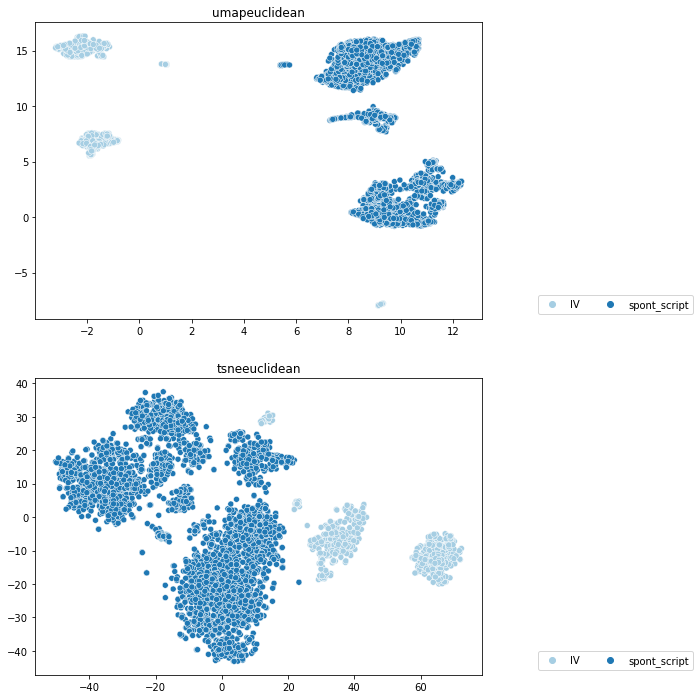

In [95]:
##plot 2 dimensions from each dimension reduction
fig, (ax1,ax2) = plt.subplots(2,figsize=(8,12))

clust_plt_umap = sns.scatterplot(x=Yumap[:,0], y=Yumap[:,1], ax=ax1, palette="Paired",hue=gemap.data_set, legend=True)
ax1.legend(loc="lower center",bbox_to_anchor=(1.3,  0), ncol=3)
clust_plt_umap.set(title = 'umap' + metric)

clust_plt_tsne = sns.scatterplot(x=Ytsne[:,0], y=Ytsne[:,1], ax=ax2, palette="Paired", hue=gemap.data_set, legend=True)
ax2.legend(loc="lower center",bbox_to_anchor=(1.3,  0), ncol=3)
clust_plt_tsne.set(title = 'tsne' + metric)

[Text(0.5, 1.0, 'tsneeuclidean')]

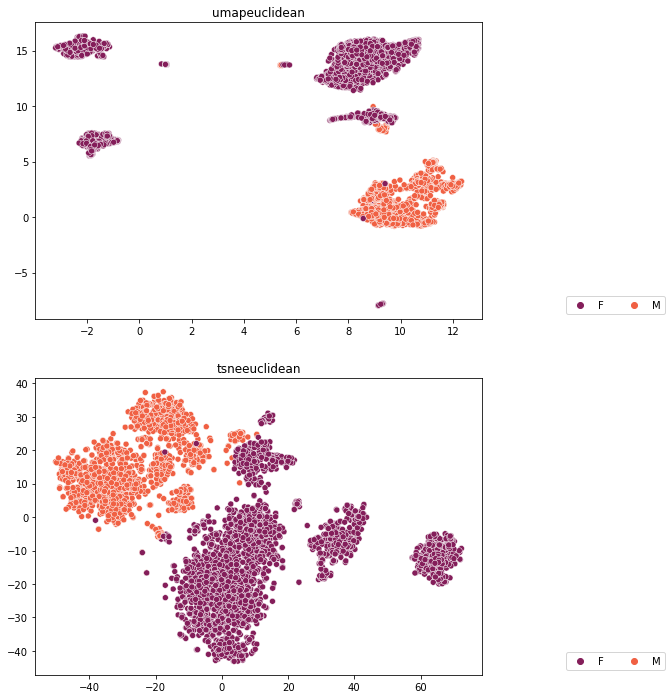

In [98]:
##plot 2 dimensions from each dimension reduction
fig, (ax1,ax2) = plt.subplots(2,figsize=(8,12))

clust_plt_umap = sns.scatterplot(x=Yumap[:,0], y=Yumap[:,1], ax=ax1, palette="rocket",hue=gemap.sex, legend=True)
ax1.legend(loc="lower center",bbox_to_anchor=(1.3,  0), ncol=3)
clust_plt_umap.set(title = 'umap' + metric)

clust_plt_tsne = sns.scatterplot(x=Ytsne[:,0], y=Ytsne[:,1], ax=ax2, palette="rocket", hue=gemap.sex, legend=True)
ax2.legend(loc="lower center",bbox_to_anchor=(1.3,  0), ncol=3)
clust_plt_tsne.set(title = 'tsne' + metric)

In [106]:
#PCA for comparison
pca_pyannote = PCA(n_components=512).fit(X)
pca_gemaps = PCA(n_components=88).fit(Y)

Xpca = pca_pyannote.transform(X)
Ypca = pca_gemaps.transform(Y)

X_exp_var = pca_pyannote.explained_variance_ratio_
Y_exp_var = pca_gemaps.explained_variance_ratio_

<AxesSubplot:>

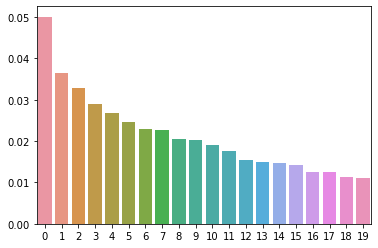

In [110]:
sns.barplot(x=np.arange(20),y=X_exp_var[0:20])

<AxesSubplot:>

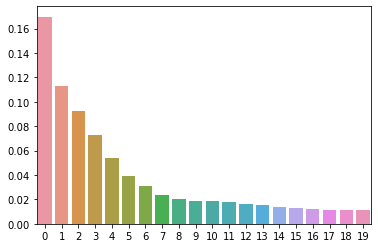

In [112]:
sns.barplot(x=np.arange(20),y=Y_exp_var[0:20])

In [143]:
X_part_count = emb.groupby('part_id').count().iloc[:,0].to_numpy()
Y_part_count = gemap.groupby('part_id').count().iloc[:,0].to_numpy()
index_len = np.minimum(Y_part_count,X_part_count)
samples_per_group_dict = dict(zip(gemap.groupby('part_id').count().index,index_len))

In [145]:
emb_reduced_samples = emb.groupby('part_id').apply(lambda group: group.sample(samples_per_group_dict[group.name])).reset_index(drop = True)
gemap_reduced_samples = gemap.groupby('part_id').apply(lambda group: group.sample(samples_per_group_dict[group.name])).reset_index(drop = True)

In [147]:
from sklearn.cross_decomposition import CCA

X_cc = emb_reduced_samples.drop(columns=labels)
Y_cc = gemap_reduced_samples.drop(columns=labels)

ca = CCA(n_components=88).fit(X_cc, Y_cc)

<AxesSubplot:>

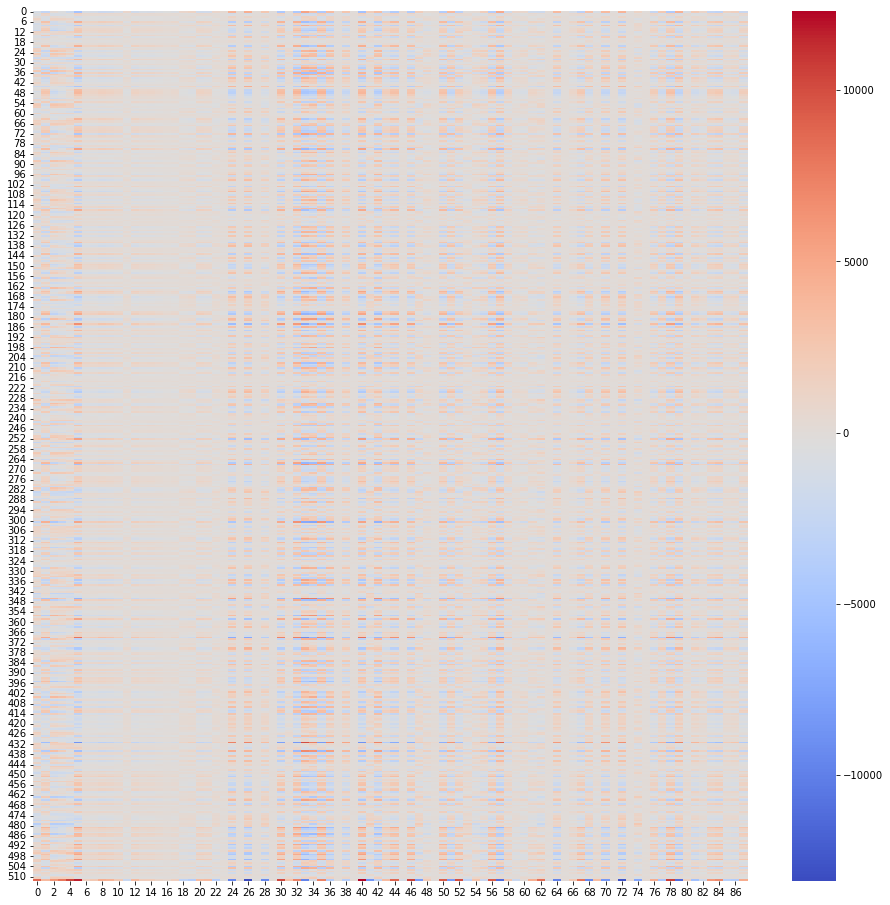

In [156]:
fig = plt.figure(figsize=(16,16))
sns.heatmap(ca.coef_, cmap="coolwarm")

